In [45]:
from tweety.filters import SearchFilters
import nest_asyncio
from tweety import TwitterAsync
import toml
import os
from pathlib import Path
import pandas as pd
import operator
import seaborn as sns

In [3]:
GLOBAL_CONFIG = {}

In [4]:
def load_config():
    with open("config/secrets.toml", "r") as toml_file:
        global GLOBAL_CONFIG
        GLOBAL_CONFIG = toml.load(toml_file)

In [5]:
load_config()

In [6]:
sess_file = Path(os.getcwd() + "/session.tw_session")

In [6]:
nest_asyncio.apply()

In [7]:
app = TwitterAsync("session")

if not sess_file.is_file():
    print("Signing in to create session file.")

    x_twitter = GLOBAL_CONFIG["x"]
    await app.sign_in(x_twitter["username"], x_twitter["password"])

else:
    print("Authenticating using session file...")
    
await app.connect()

Authenticating using session file...


User(id=16975132, username=MohdFaizuddin, name=Faiz, verified=False)

In [8]:
search_keywords = "UniKL Kuala Lumpur"

In [9]:
tweets = await app.search(search_keywords, pages=10, filter_=SearchFilters.Latest(), wait_time=5)

In [10]:
id = []
created_on = []
date = []
text = []
rich_text = []
author = []
is_retweet = []
retweeted_tweet = []
is_quoted = []
quoted_tweet = []
is_reply = []
is_sensitive = []
reply_counts = []
quote_counts = []
replied_to = []
bookmark_count = []
views = []
likes = []
language = []
place = []
retweet_counts = []
source = []
has_moderated_replies = []
is_liked = []
is_retweeted = []
can_reply = []
broadcast = []
edit_control = []
has_newer_version = []
audio_space_id = []
pool = []
community = []
media = []
user_mentions = []
urls = []
hashtags = []
symbols = []
community_note = []
url = []
grok_share = []
threads = []
comments = []


In [11]:
for t in tweets:
    id.append(t["id"])
    created_on.append(t["created_on"])
    date.append(t["date"])
    text.append(t["text"])
    rich_text.append(t["rich_text"])
    author.append(t["author"])
    is_retweet.append(t["is_retweet"])
    retweeted_tweet.append(t["retweeted_tweet"])
    is_quoted.append(t["is_quoted"])
    quoted_tweet.append(t["quoted_tweet"])
    is_reply.append(t["is_reply"])
    is_sensitive.append(t["is_sensitive"])
    reply_counts.append(t["reply_counts"])
    quote_counts.append(t["quote_counts"])
    replied_to.append(t["replied_to"])
    bookmark_count.append(t["bookmark_count"])
    views.append(t["views"])
    likes.append(t["likes"])
    language.append(t["language"])
    place.append(t["place"])
    retweet_counts.append(t["retweet_counts"])
    source.append(t["source"])
    has_moderated_replies.append(t["has_moderated_replies"])
    is_liked.append(t["is_liked"])
    is_retweeted.append(t["is_retweeted"])
    can_reply.append(t["can_reply"])
    broadcast.append(t["broadcast"])
    edit_control.append(t["edit_control"])
    has_newer_version.append(t["has_newer_version"])
    audio_space_id.append(t["audio_space_id"])
    pool.append(t["pool"])
    community.append(t["community"])
    media.append(t["media"])
    user_mentions.append(t["user_mentions"])
    urls.append(t["urls"])
    hashtags.append(t["hashtags"])
    symbols.append(t["symbols"])
    community_note.append(t["community_note"])
    url.append(t["url"])
    grok_share.append(t["grok_share"])
    threads.append(t["threads"])
    comments.append(t["comments"])

In [12]:
df = pd.DataFrame(list(zip(id,
                           created_on,
                           date,
                           text,
                           rich_text,
                           author,
                           is_retweet,
                           retweeted_tweet,
                           is_quoted,
                           quoted_tweet,
                           is_reply,
                           is_sensitive,
                           reply_counts,
                           quote_counts,
                           replied_to,
                           bookmark_count,
                           views,
                           likes,
                           language,
                           place,
                           retweet_counts,
                           source,
                           has_moderated_replies,
                           is_liked,
                           is_retweeted,
                           can_reply,
                           broadcast,
                           edit_control,
                           has_newer_version,
                           audio_space_id,
                           pool,
                           community,
                           media,
                           user_mentions,
                           urls,
                           hashtags,
                           symbols,
                           community_note,
                           url,
                           grok_share,
                           threads,
                           comments)), columns=["id",
                           "created_on",
                           "date",
                           "text",
                           "rich_text",
                           "author",
                           "is_retweet",
                           "retweeted_tweet",
                           "is_quoted",
                           "quoted_tweet",
                           "is_reply",
                           "is_sensitive",
                           "reply_counts",
                           "quote_counts",
                           "replied_to",
                           "bookmark_count",
                           "views",
                           "likes",
                           "language",
                           "place",
                           "retweet_counts",
                           "source",
                           "has_moderated_replies",
                           "is_liked",
                           "is_retweeted",
                           "can_reply",
                           "broadcast",
                           "edit_control",
                           "has_newer_version",
                           "audio_space_id",
                           "pool",
                           "community",
                           "media",
                           "user_mentions",
                           "urls",
                           "hashtags",
                           "symbols",
                           "community_note",
                           "url",
                           "grok_share",
                           "threads",
                           "comments"])

In [13]:
df

,id,created_on,date,text,rich_text,author,is_retweet,retweeted_tweet,is_quoted,quoted_tweet,...,media,user_mentions,urls,hashtags,symbols,community_note,url,grok_share,threads,comments
0,1875088823933423672,2025-01-03 07:56:27+00:00,2025-01-03 07:56:27+00:00,🏆🔥 Get ready for SSUK 2025 (Sukan Staf Univers...,None,"{'id': '1599686497', 'rest_id': '1599686497', ...",False,None,False,None,...,"[{'display_url': 'pic.x.com/72AAon05MX', 'expa...",[],[],[],[],None,https://twitter.com/UniKLOfficial/status/18750...,None,[],[]
1,1869954031227113538,2024-12-20 03:52:37+00:00,2024-12-20 03:52:37+00:00,You 've made UniKL proud and looking forward m...,None,"{'id': '948552280604786691', 'rest_id': '94855...",False,None,False,None,...,[],[],[],[],[],None,https://twitter.com/unikl_mestech/status/18699...,None,[],[]
2,1869248718853279936,2024-12-18 05:09:58+00:00,2024-12-18 05:09:58+00:00,"On 17 December 2024, the CEO of Bond Pricing A...",None,"{'id': '232836641', 'rest_id': '232836641', 'c...",False,None,False,None,...,"[{'display_url': 'pic.x.com/kUjsbS7w8o', 'expa...",[],[],"[{'indices': [239, 255], 'text': 'connectwithb...",[],None,https://twitter.com/BPA_Malaysia/status/186924...,None,[],[]
3,1868237421382668593,2024-12-15 10:11:26+00:00,2024-12-15 10:11:26+00:00,We Are UniKL 💛💙\n\nHighlight video during Inte...,None,"{'id': '1599686497', 'rest_id': '1599686497', ...",False,None,False,None,...,"[{'display_url': 'pic.x.com/w0lnSMSp5E', 'expa...",[],[],[],[],None,https://twitter.com/UniKLOfficial/status/18682...,None,[],[]
4,1868236826168918385,2024-12-15 10:09:04+00:00,2024-12-15 10:09:04+00:00,Photos during International Student (Undergrad...,None,"{'id': '1599686497', 'rest_id': '1599686497', ...",False,None,False,None,...,"[{'display_url': 'pic.x.com/loUBucdna3', 'expa...",[],[],[],[],None,https://twitter.com/UniKLOfficial/status/18682...,None,[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,1740219894325715200,2023-12-28 03:55:29+00:00,2023-12-28 03:55:29+00:00,Selamat kepada Fachri Insan Hidayatulloh dari ...,None,"{'id': '771337601269714944', 'rest_id': '77133...",False,None,False,None,...,"[{'display_url': 'pic.x.com/70bzrPIXrU', 'expa...","[{'id': '253418739', 'name': 'Khofifah Indar P...",[],[],[],None,https://twitter.com/JatimPemprov/status/174021...,None,[],[]
184,1739869878545498131,2023-12-27 04:44:38+00:00,2023-12-27 04:44:38+00:00,Sesi taklimat Kursus Qualcomm 5G University Pr...,None,"{'id': '930967808271192064', 'rest_id': '93096...",False,None,False,None,...,"[{'display_url': 'pic.x.com/np7XKMR4Mp', 'expa...",[],[],[],[],None,https://twitter.com/tecmalaysia/status/1739869...,None,[],[]
185,1738736123726401966,2023-12-24 01:39:30+00:00,2023-12-24 01:39:30+00:00,Majlis penyerahan Zakat oleh Assoc. Prof. Cdr....,None,"{'id': '839131109640163331', 'rest_id': '83913...",False,None,False,None,...,"[{'display_url': 'pic.x.com/EDymPA1sYw', 'expa...",[],[],[],[],None,https://twitter.com/UniKLMIMET/status/17387361...,None,[],[]
186,1738035918727229680,2023-12-22 03:17:08+00:00,2023-12-22 03:17:08+00:00,Makmal Kejuruteraan Nilai (VE Lab) bagi projek...,None,"{'id': '956325220603723777', 'rest_id': '95632...",False,None,False,None,...,"[{'display_url': 'pic.x.com/viWjDgCxY2', 'expa...","[{'id': '3855751879', 'name': 'Badio', 'screen...",[],[],[],None,https://twitter.com/CKBA2_JKR/status/173803591...,None,[],[]


In [16]:
# append search keywords column
df["search_keywords"] = search_keywords

In [8]:
from pymongo import MongoClient

mongo_conf = GLOBAL_CONFIG["mongo"]
client = MongoClient(mongo_conf["mongo_uri"])
db = client[mongo_conf["mongo_db"]]
coll = mongo_conf["mongo_col"]

In [18]:
def create_profiles_collection(db, collection_name, validator=None):
    if collection_name not in db.list_collection_names():
        if validator:
            db.create_collection(collection_name, validator=validator)
        else:
            db.create_collection(collection_name)
    else:
        print(f"Collection '{collection_name}' already exists.")

In [19]:
create_profiles_collection(db, coll)

In [20]:
def insert_data_to_mongo(db, collection_name, data_frame):
    collection = db[collection_name]
    records = data_frame.to_dict(orient='records')
    collection.insert_many(records)

In [21]:
insert_data_to_mongo(db, coll, df)

In [9]:
profiles_collection = db[coll]
cursor = profiles_collection.find()

In [10]:
list_cur = list(cursor)
dataset = pd.DataFrame(list_cur)

In [25]:
dataset.loc[2, "hashtags"]

[{'indices': [239, 255], 'text': 'connectwithbpam'},
 {'indices': [256, 262], 'text': 'unikl'},
 {'indices': [263, 272], 'text': 'malaysia'},
 {'indices': [273, 279], 'text': 'bonds'}]

### Text preprocessing

In [11]:
import malaya

/home/faiz/anaconda3/envs/work/lib/python3.10/site-packages/malaya/tokenizer.py:214: FutureWarning: Possible nested set at position 3397
  self.tok = re.compile(r'({})'.format('|'.join(pipeline)))
/home/faiz/anaconda3/envs/work/lib/python3.10/site-packages/malaya/tokenizer.py:214: FutureWarning: Possible nested set at position 3927
  self.tok = re.compile(r'({})'.format('|'.join(pipeline)))


In [70]:
def preprocess_text(text):
    # demoji
    demoji = malaya.preprocessing.demoji()
    demoji_text = demoji.demoji(text)

    # malaya preprocessing
    preproc = malaya.preprocessing.preprocessing(demoji=demoji)
    preproc_text = "".join(preproc.process(text))

    for k,v in demoji_text.items():
        preproc_text = preproc_text.replace(k,v)

    w_tokeniser = malaya.tokenizer.Tokenizer()
    s_tokeniser = malaya.tokenizer.SentenceTokenizer()

    w_tokens = w_tokeniser.tokenize(preproc_text, lowercase=True)
    # s_tokens = s_tokeniser.tokenize(preproc_text)

    return "".join(w_tokens)

In [71]:
texts = []

for text in dataset["text"]:
    texts.append(preprocess_text(text))

In [49]:
import operator
fast_text = malaya.language_detection.fasttext()

langs = []
lang_probas = []

for text in dataset["text"]:
    prob_dict = fast_text.predict_proba([text])

    lang = max(prob_dict[0].items(), key=operator.itemgetter(1))[0]
    prob = max(prob_dict[0].items(), key=operator.itemgetter(1))[1]

    langs.append(lang)
    lang_probas.append(prob)

In [50]:
lang_df = pd.DataFrame(list(zip(langs, lang_probas)), columns=["language", "language_probability"])

In [51]:
lang_df

,language,language_probability
0,manglish,0.806866
1,local-english,0.791622
2,local-english,0.513222
3,standard-english,0.382878
4,local-english,0.553134
...,...,...
183,standard-malay,0.793704
184,standard-malay,0.882033
185,local-malay,0.747472
186,standard-malay,0.932277


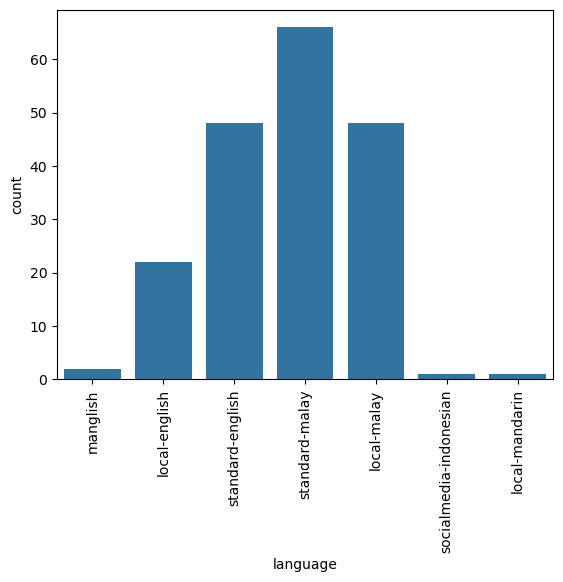

In [65]:
plot = sns.countplot(lang_df, x="language")
plot.tick_params(axis='x', rotation=90)

#### Translation to Malay language (ms)

In [56]:
trans_model = malaya.translation.huggingface(model = 'mesolitica/translation-nanot5-small-malaysian-cased')

tokenizer_config.json:   0%|          | 0.00/754 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/517k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/303k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.59k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/819 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/358M [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


generation_config.json:   0%|          | 0.00/164 [00:00<?, ?B/s]

In [58]:
dataset.loc[187, "text"]

'An energetic group of 10 lecturers with deep passion for science from Universiti Kuala Lumpur Royal College of Medicine Perak (UniKL RCMP) have recently visited #Novugen’s USFDA approved pharmaceutical and oncology manufacturing facilities on 13th of December 2023. https://t.co/uUkZAYgoE5'

In [62]:
trans_model.generate([dataset.loc[3, "text"]], to_lang = 'ms', max_length = 1000)

['Kami UniKL 💛💙\n\nVideo highlight semasa Penglibatan Pelajar Antarabangsa (Belajar): September & Oktober 2024 Pengambilan di Pusat Bandar Perdana Kuala Lumpur, 14 Disember 2024 🎥 https://t.co/w0lnSMSp5E']

In [65]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   _id                    188 non-null    object        
 1   id                     188 non-null    object        
 2   created_on             188 non-null    datetime64[ns]
 3   date                   188 non-null    datetime64[ns]
 4   text                   188 non-null    object        
 5   rich_text              27 non-null     object        
 6   author                 188 non-null    object        
 7   is_retweet             188 non-null    object        
 8   retweeted_tweet        0 non-null      object        
 9   is_quoted              188 non-null    object        
 10  quoted_tweet           1 non-null      object        
 11  is_reply               188 non-null    object        
 12  is_sensitive           188 non-null    object        
 13  reply

## Sentiment analysis

In [66]:
malaya.sentiment.available_huggingface

{'mesolitica/sentiment-analysis-nanot5-tiny-malaysian-cased': {'Size (MB)': 93,
  'macro precision': 0.67768,
  'macro recall': 0.68266,
  'macro f1-score': 0.67997},
 'mesolitica/sentiment-analysis-nanot5-small-malaysian-cased': {'Size (MB)': 167,
  'macro precision': 0.67602,
  'macro recall': 0.6712,
  'macro f1-score': 0.67339}}

In [67]:
print(malaya.sentiment.info)

Trained on https://huggingface.co/datasets/mesolitica/chatgpt-explain-sentiment
Split 90% to train, 10% to test.


In [68]:
# load model from Huggingface
sentiment_model = malaya.sentiment.huggingface(model="mesolitica/sentiment-analysis-nanot5-small-malaysian-cased")

In [72]:
sentiments = []
sentiment_probas = []
for i, text in enumerate(texts):
    if text:
        prob_dict = sentiment_model.predict_proba([text])
        sentiment = max(prob_dict[0].items(), key=operator.itemgetter(1))[0]
        sentiment_prob = max(prob_dict[0].items(), key=operator.itemgetter(1))[1]
    else:
        sentiment = "neutral"
        sentiment_prob = 0.000
    
    sentiments.append(sentiment)
    sentiment_probas.append(sentiment_prob)

In [73]:
sentiment_df = pd.DataFrame(list(zip(sentiments, sentiment_probas)), columns=["sentiment", "sentiment_probability"])

,sentiment,sentiment_probability
0,positive,0.679903
1,positive,0.955390
2,neutral,0.611747
3,neutral,0.981847
4,neutral,0.884309
...,...,...
183,neutral,0.559100
184,positive,0.938196
185,neutral,0.736944
186,neutral,0.684105


In [74]:
import seaborn as sns

<Axes: xlabel='sentiment', ylabel='count'>

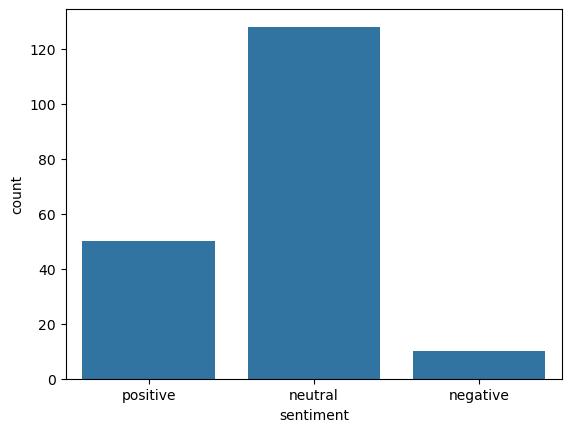

In [76]:
sns.countplot(sentiment_df, x="sentiment")

<Axes: xlabel='sentiment_probability', ylabel='Count'>

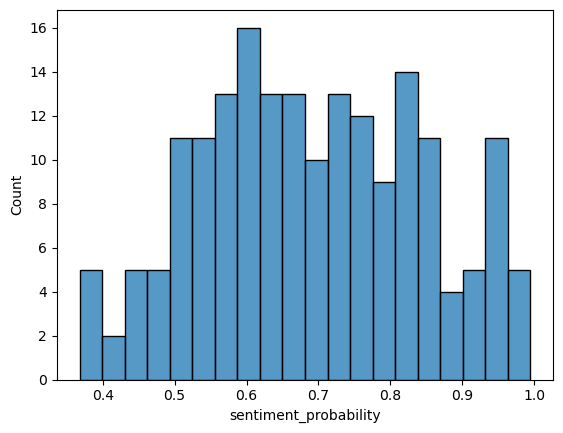

In [96]:
sns.histplot(sentiment_df, x="sentiment_probability", bins=20)

Text(0.5, 1.0, 'Probability Distribution for Neutral Sentiments')

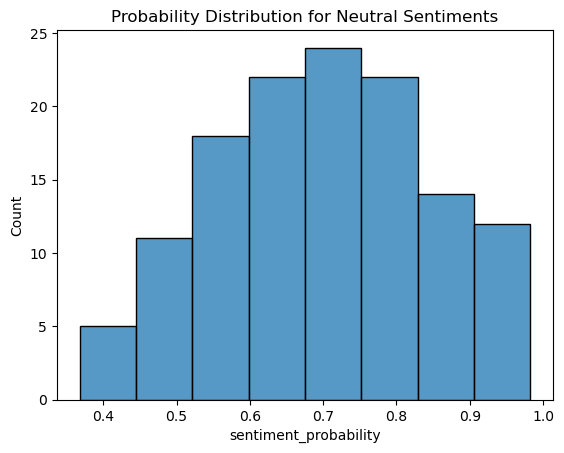

In [103]:
sns.histplot(sentiment_df[sentiment_df["sentiment"]=="neutral"], x="sentiment_probability", bins=8).set_title("Probability Distribution for Neutral Sentiments")

### Emotion Analysis

In [12]:
malaya.emotion.available_huggingface

{'mesolitica/emotion-analysis-nanot5-tiny-malaysian-cased': {'Size (MB)': 93,
  'macro precision': 0.96107,
  'macro recall': 0.9627,
  'macro f1-score': 0.96182},
 'mesolitica/emotion-analysis-nanot5-small-malaysian-cased': {'Size (MB)': 167,
  'macro precision': 0.96814,
  'macro recall': 0.97004,
  'macro f1-score': 0.96905}}

In [105]:
print(malaya.emotion.info)

Trained on https://github.com/huseinzol05/malaysian-dataset/tree/master/corpus/emotion
Split 80% to train, 20% to test.


In [13]:
# load malaya emotion model from Huggingface
emo_model = malaya.emotion.huggingface(model="mesolitica/emotion-analysis-nanot5-small-malaysian-cased")

#### Text preprocessing

In [14]:
demoji = malaya.preprocessing.demoji()
preprocessing = malaya.preprocessing.preprocessing(demoji=demoji)

proc_texts = []

for t in dataset["text"]:
    demoji_text = demoji.demoji(t)
    joined = " ".join(preprocessing.process(t))
    for k,v in demoji_text.items():
        joined = joined.replace(k,v)

    proc_texts.append(joined)    

/home/faiz/anaconda3/envs/work/lib/python3.10/site-packages/malaya/preprocessing.py:41: FutureWarning: Possible nested set at position 42
  k.lower(): re.compile(_expressions[k]) for k, v in _expressions.items()
/home/faiz/anaconda3/envs/work/lib/python3.10/site-packages/malaya/preprocessing.py:41: FutureWarning: Possible nested set at position 3
  k.lower(): re.compile(_expressions[k]) for k, v in _expressions.items()


In [15]:
proc_texts

['<emoji> trofi </emoji> <emoji> api </emoji> Get ready untuk <allcaps> SSUK </allcaps> <number> ( Sukan Staf Universiti Kuala Lumpur ) ! <emoji> kalendar </emoji> Date : <number> – <number> January <number> <emoji> pusingan pusingan pusingan </emoji> Venue : UniKL <allcaps> MIAT </allcaps> Cheer on awak teams and witness the spirit of sportsmanship and unity ! <emoji> Biceps flexed </emoji> Stay tuned untuk more updates ! <url>',
 "You ' ve made UniKL proud and looking forward more success from awak in the future . <emoji> Pingat tempat ke -2 </emoji> 2nd prize ( <allcaps> USD </allcaps> <number> ) dengan the project title Plant Elixir from UniKL <allcaps> MESTECH </allcaps> . Once again , congratulations from semua of us ! <emoji> wajah tersenyum dengan mata hati </emoji> Universiti Kuala Lumpur - Unikl",
 'On <number> December <number> , the <allcaps> CEO </allcaps> of Bond Pricing Agency Malaysia ( <allcaps> BPAM </allcaps> ) , Meor Amri Meor Ayob , delivered an insightful talk tit

In [42]:
import operator

emotions = []
emotion_probas = []
for i, text in enumerate(proc_texts):
    if text:
        prob_dict = emo_model.predict_proba([text])
        emotion = max(prob_dict[0].items(), key=operator.itemgetter(1))[0]
        emotion_prob = max(prob_dict[0].items(), key=operator.itemgetter(1))[1]
    else:
        emotion = "no emotion"
        emotion_prob = 0.000
    
        
    emotions.append(emotion)
    emotion_probas.append(emotion_prob)

In [46]:
emotion_df = pd.DataFrame(list(zip(emotions, emotion_probas)), columns=["emotion", "emotion_probability"])

In [47]:
emotion_df["text"] = dataset["text"]

In [ ]:
emotion_df

<Axes: xlabel='emotion', ylabel='count'>

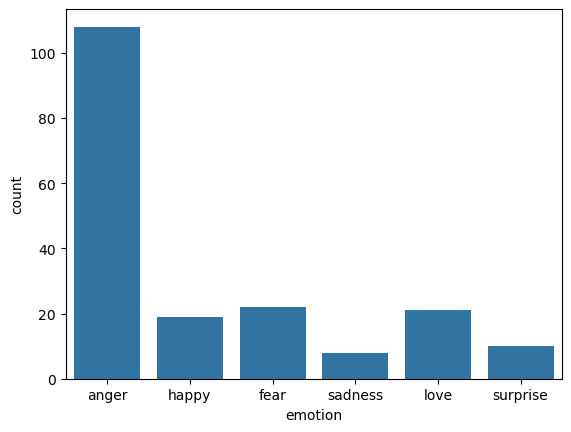

In [48]:
sns.countplot(emotion_df, x="emotion")